# IPL Playoff Qualification Probability Analysis (Max 2 Consecutive Wins)
## Introduction
In the Indian Premier League (IPL), each team plays 14 matches in the league stage. Typically, **7 wins (14 points)** give a team a chance to qualify for the playoffs, but it's not guaranteed unless the **Net Run Rate (NRR)** is favorable. Teams with **8 wins (16 points)** are almost always safe.

This notebook analyzes how likely it is for a team to qualify if they **never win more than 2 matches in a row**. We explore this using both:
- **Combinatorics** (pure math, all outcomes equally likely)
- **Simulations** (realistic win probabilities like 40%, 50%, and 60%)

## Imports and Setup

In [1]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import random
import plotly.graph_objects as go


## Parameters and Helper Functions

In [2]:
TOTAL_MATCHES = 14
QUALIFY_WIN_THRESHOLD = 7
STRICT_QUALIFY_THRESHOLD = 8

def is_valid_sequence(seq):
    """Return True if sequence has no more than 2 consecutive wins."""
    count = 0
    for outcome in seq:
        if outcome == 'W':
            count += 1
            if count > 2:
                return False
        else:
            count = 0
    return True

def count_wins(seq):
    return seq.count('W')

## Section 1: Combinatorics (Math Model)

In [3]:
all_sequences = list(itertools.product(['W', 'L'], repeat=TOTAL_MATCHES))
valid_sequences = [seq for seq in all_sequences if is_valid_sequence(seq)]

qualifying_7plus = [seq for seq in valid_sequences if count_wins(seq) >= QUALIFY_WIN_THRESHOLD]
qualifying_8plus = [seq for seq in valid_sequences if count_wins(seq) >= STRICT_QUALIFY_THRESHOLD]

print(f"Total sequences: {len(all_sequences)}")
print(f"Valid sequences (no >2 consecutive wins): {len(valid_sequences)}")
print(f"Qualifying sequences (7+ wins): {len(qualifying_7plus)}")
print(f"Strict qualifying sequences (8+ wins): {len(qualifying_8plus)}")

Total sequences: 16384
Valid sequences (no >2 consecutive wins): 5768
Qualifying sequences (7+ wins): 1424
Strict qualifying sequences (8+ wins): 408


### Win Distribution in Valid Sequences

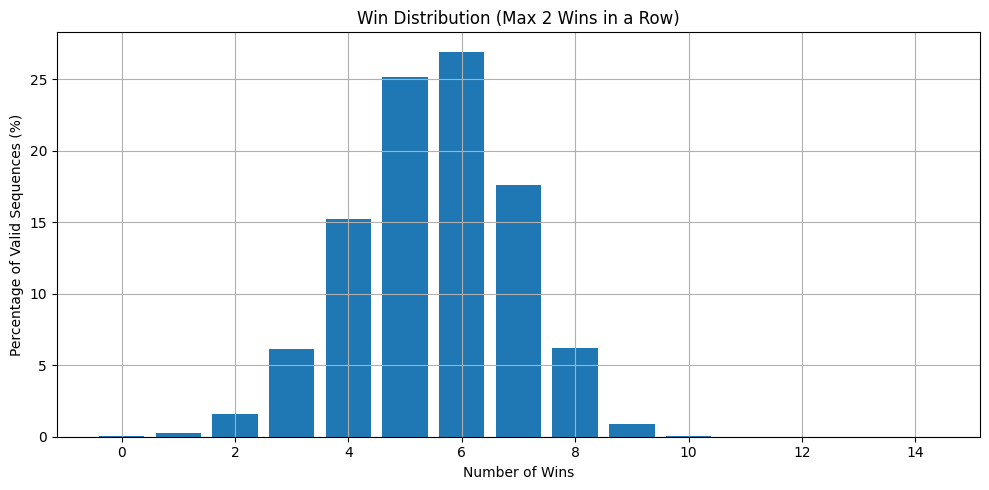

In [4]:
win_distribution = {i: 0 for i in range(15)}
for seq in valid_sequences:
    win_distribution[count_wins(seq)] += 1

win_df = pd.DataFrame(list(win_distribution.items()), columns=['Wins', 'Valid Sequence Count'])
win_df['Percentage'] = (win_df['Valid Sequence Count'] / len(valid_sequences)) * 100

plt.figure(figsize=(10, 5))
plt.bar(win_df['Wins'], win_df['Percentage'])
plt.xlabel('Number of Wins')
plt.ylabel('Percentage of Valid Sequences (%)')
plt.title('Win Distribution (Max 2 Wins in a Row)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Section 2: Simulated Seasons

In [6]:
def simulate_with_prob(p_win, num_simulations=100000):
    qualifying_7, qualifying_8 = 0, 0
    for _ in range(num_simulations):
        seq = []
        win_streak = 0
        for _ in range(TOTAL_MATCHES):
            if win_streak == 2:
                seq.append('L')
                win_streak = 0
            else:
                outcome = 'W' if random.random() < p_win else 'L'
                seq.append(outcome)
                win_streak = win_streak + 1 if outcome == 'W' else 0
        wins = seq.count('W')
        if wins >= QUALIFY_WIN_THRESHOLD:
            qualifying_7 += 1
        if wins >= STRICT_QUALIFY_THRESHOLD:
            qualifying_8 += 1
    return round(qualifying_7 / num_simulations * 100, 2), round(qualifying_8 / num_simulations * 100, 2)

results = {}
for label, p in zip(['Weak (40%)', 'Average (50%)', 'Strong (60%)'], [0.4, 0.5, 0.6]):
    q7, q8 = simulate_with_prob(p)
    results[label] = {'7+ Wins': q7, '8+ Wins': q8}
    print(f"{label}: 7+ Wins = {q7}%, 8+ Wins = {q8}%")

Weak (40%): 7+ Wins = 17.13%, 8+ Wins = 4.43%
Average (50%): 7+ Wins = 40.78%, 8+ Wins = 15.67%
Strong (60%): 7+ Wins = 67.87%, 8+ Wins = 37.05%


## Section 3: Final Comparison: Math vs Simulation

In [7]:
labels = list(results.keys())
sim_7plus = [results[l]['7+ Wins'] for l in labels]
sim_8plus = [results[l]['8+ Wins'] for l in labels]
comb_7plus = [8.69]*3
comb_8plus = [2.49]*3
sim_7only = [sim_7plus[i] - sim_8plus[i] for i in range(3)]
comb_7only = [comb_7plus[i] - comb_8plus[i] for i in range(3)]

fig = go.Figure()
fig.add_trace(go.Bar(x=labels, y=comb_7only, name='7 Wins Only (Math Model)', marker_color='#7eb6ff'))
fig.add_trace(go.Bar(x=labels, y=comb_8plus, name='8+ Wins (Math Model)', marker_color='#007acc'))
fig.add_trace(go.Bar(x=labels, y=sim_7only, name='7 Wins Only (Simulated)', marker_color='#ffd78f'))
fig.add_trace(go.Bar(x=labels, y=sim_8plus, name='8+ Wins (Simulated)', marker_color='#ff8c00'))
fig.update_layout(
    barmode='group',
    title='Playoff Qualification: Math vs Simulated Outcomes',
    xaxis_title='Team Strength',
    yaxis_title='Qualification Probability (%)',
    legend_title='Scenario',
    height=600
)
fig.show()